In [1]:
import torch                               
import DNNI
import matplotlib.pyplot as plt           # plotting
from scipy.integrate import quad
torch.set_default_tensor_type(torch.DoubleTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
print(device)
if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cpu


In [2]:
#LHS
be=1;alpha=1;
def tridiag(n, k1=-1, k2=0, k3=1):
    h=float(1/n) 
    b=2*be*h*np.ones(n)/3
    a=(-3*alpha+be*h)*np.ones(n-1)/6
    c=(3*alpha+be*h)*np.ones(n-1)/6
    td = np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)
    td[n-1,n-1] = (3*alpha+2*be*h)/6 
    return td
tridiag(3)

array([[ 0.22222222,  0.55555556,  0.        ],
       [-0.44444444,  0.22222222,  0.55555556],
       [ 0.        , -0.44444444,  0.61111111]])

In [3]:
from pylab import *
from scipy.special.orthogonal import p_roots

def gauss(f,n,a,b):
    [x,w] = p_roots(n+1)
    G=0.5*(b-a)*sum(w*f(0.5*(b-a)*x+0.5*(b+a)))
    return G
def force(n):
    alpha=1;h=float(1/n);be=1
    a=(-3*alpha+be*h)/6
    X = np.linspace(0,1,n+1)
    R = np.ones(int(n))
    #u_0 = 1
    R[0] = n*gauss(lambda x:(X[1]-x)*np.cos(2*x),32,X[0],X[1])#-a*u_0
    for i in range(int(n-1)):
        R[i+1] = n*(gauss(lambda x:(x-X[i])*np.cos(2*x),32,X[i],X[i+1])+gauss(lambda x:(X[i+2]-x)*np.cos(2*x),32,X[i+1],X[i+2]))
    R[n-1] = n*(gauss(lambda x:(x-X[n-1])*np.cos(2*x),32,X[n-1],X[n]))
    return R
force(9)

array([ 0.05532731,  0.10793363,  0.09990448,  0.08696205,  0.06974284,
        0.04909369,  0.02603012,  0.0016864 , -0.01929155])

In [4]:
from scipy import linalg
def q(n,func):
    lhs = tridiag(n)
    rhs= func(n)
    return np.linalg.solve(lhs,rhs)

def phi(i,x,n):
    X = np.linspace(0,1,n)
    h = X[1]-X[0]
    if i==0: 
        if x > X[1]:
            v = 0;
        else:
            v = (X[1]-x)/h;
    elif i==n-1:
        if(x<X[n-2]):
            v = 0;
        else:
            v = (x-X[n-2])/h;
    else:
        if(x>X[i+1] or x<X[i-1] ):
            v = 0;
        elif(x<=X[i]):
            v = (x-X[i-1])/h;
        else:
            v = (X[i+1]-x)/h;
    return v

# Comparison

In [5]:
def usingFEM(n):
    start = time.time()
    x1 = np.linspace(0,1,10)
    U = np.linspace(0,1,10)
    c = q(n,force)
    for i in range(1,10):
        u=0
        for j in range(n):
            u = u+ c[j]*phi(j,x1[i],n)
        U[i] = u
    actual=1/5*(-np.exp(-x1)+2*np.sin(2*x1)+np.cos(2*x1))
    mse = np.mean(np.abs(actual-U))
    t = time.time()-start
    return t,mse

In [6]:
def f1(x):
        return torch.cos(2*x)
def f2(x):    
        return x*torch.cos(2*x)

In [7]:
def get_int(n,iters):
    steps=iters
    x = torch.linspace(0,1,1000).view(-1,1)
    layers = np.array([1,10,10,10,1])
    inn = DNNI.DNNI(layers,device)
    inn.to(device)
    inn.closure(steps=steps,x_train=x,int_f=f1,show=False)
    x_test1 = torch.linspace(0,1,n+1).view(-1,1)
    y1 = inn(x_test1).detach().cpu().numpy()
    #plt.plot(y1-y1[0])
    
    steps=iters
    x = torch.linspace(0,1,1000).view(-1,1)
    layers = np.array([1,10,10,10,1])
    inn2 = DNNI.DNNI(layers,device)
    inn2.to(device)
    inn2.closure(steps=steps,x_train=x,int_f=f2,show=False)
    x_test2 = torch.linspace(0,1,n+1).view(-1,1)
    y2 = inn2(x_test2).detach().cpu().numpy()
    #plt.plot(y2-y2[0])
    return y1,y2

In [8]:
def force_nn(n,y1,y2):
    alpha=1;h=float(1/n);
    a=(-3*alpha)/6
    X = np.linspace(0,1,n+1)
    R = np.ones(int(n))
    u_0 = 0
    R[0] = n*(-y2[1]+y2[0]+X[1]*(y1[1]-y1[0]))#-a*u_0
    for j in range(n-1):
        R[j+1] = n*(y2[j+1]-y2[j]-X[j]*(y1[j+1]-y1[j]) + X[j+2]*(y1[j+2]-y1[j+1])-(y2[j+2]-y2[j+1]))
    R[n-1] = n*(y2[n]-y2[n-1]-X[n-1]*(y1[n]-y1[n-1]))
    return R
def solver_nn(x,n,func,y1,y2):
    c = q_nn(n,func,y1,y2)
    #plt.plot(c)
    u=0
    for i in range(n):
        u = u+ c[i]*phi(i,x,n)
    return u
def q_nn(n,func,y1,y2):
    lhs = tridiag(n)
    rhs= func(n,y1,y2)
    return np.linalg.solve(lhs,rhs)


def usingDNNI(n,iters):
    start = time.time()
    x1 = np.linspace(0,1,10)
    U = np.linspace(0,1,10)
    y1,y2 = get_int(n,iters)
    c = q_nn(n,force_nn,y1,y2) #only this is different between both
    for i in range(1,10):
        u=0
        for j in range(n):
            u = u+ c[j]*phi(j,x1[i],n)
        U[i] = u
    actual=1/5*(-np.exp(-x1)+2*np.sin(2*x1)+np.cos(2*x1))
    mse = np.mean(np.abs(actual-U))
    t = time.time()-start
    return t,mse

In [15]:
y1,y2 = get_int(5,5000)
force_nn(5,y1,y2)

100%|██████████| 5000/5000 [00:09<00:00, 545.23it/s]


array([ 0.09878196,  0.18162465,  0.13721489,  0.07236861, -0.02873386])

In [16]:
force(5)

array([ 0.09867376,  0.1817691 ,  0.13749334,  0.0715104 , -0.02903543])

In [9]:
time_gele = []
time_dnni = []
for i in range(5):# for test 1 use range(2)
    time1 = []
    time2 = []
    for i in range(1,11):
        time1.append(usingFEM(i*4400)[0])
        time2.append(usingDNNI(i*4400,1000)[0])# keeping it 1000 for less computation time. Increasing it will increase the no of nodes for break even point
    time_gele.append(time1)
    time_dnni.append(time2)    

100%|██████████| 1000/1000 [00:01<00:00, 536.11it/s]


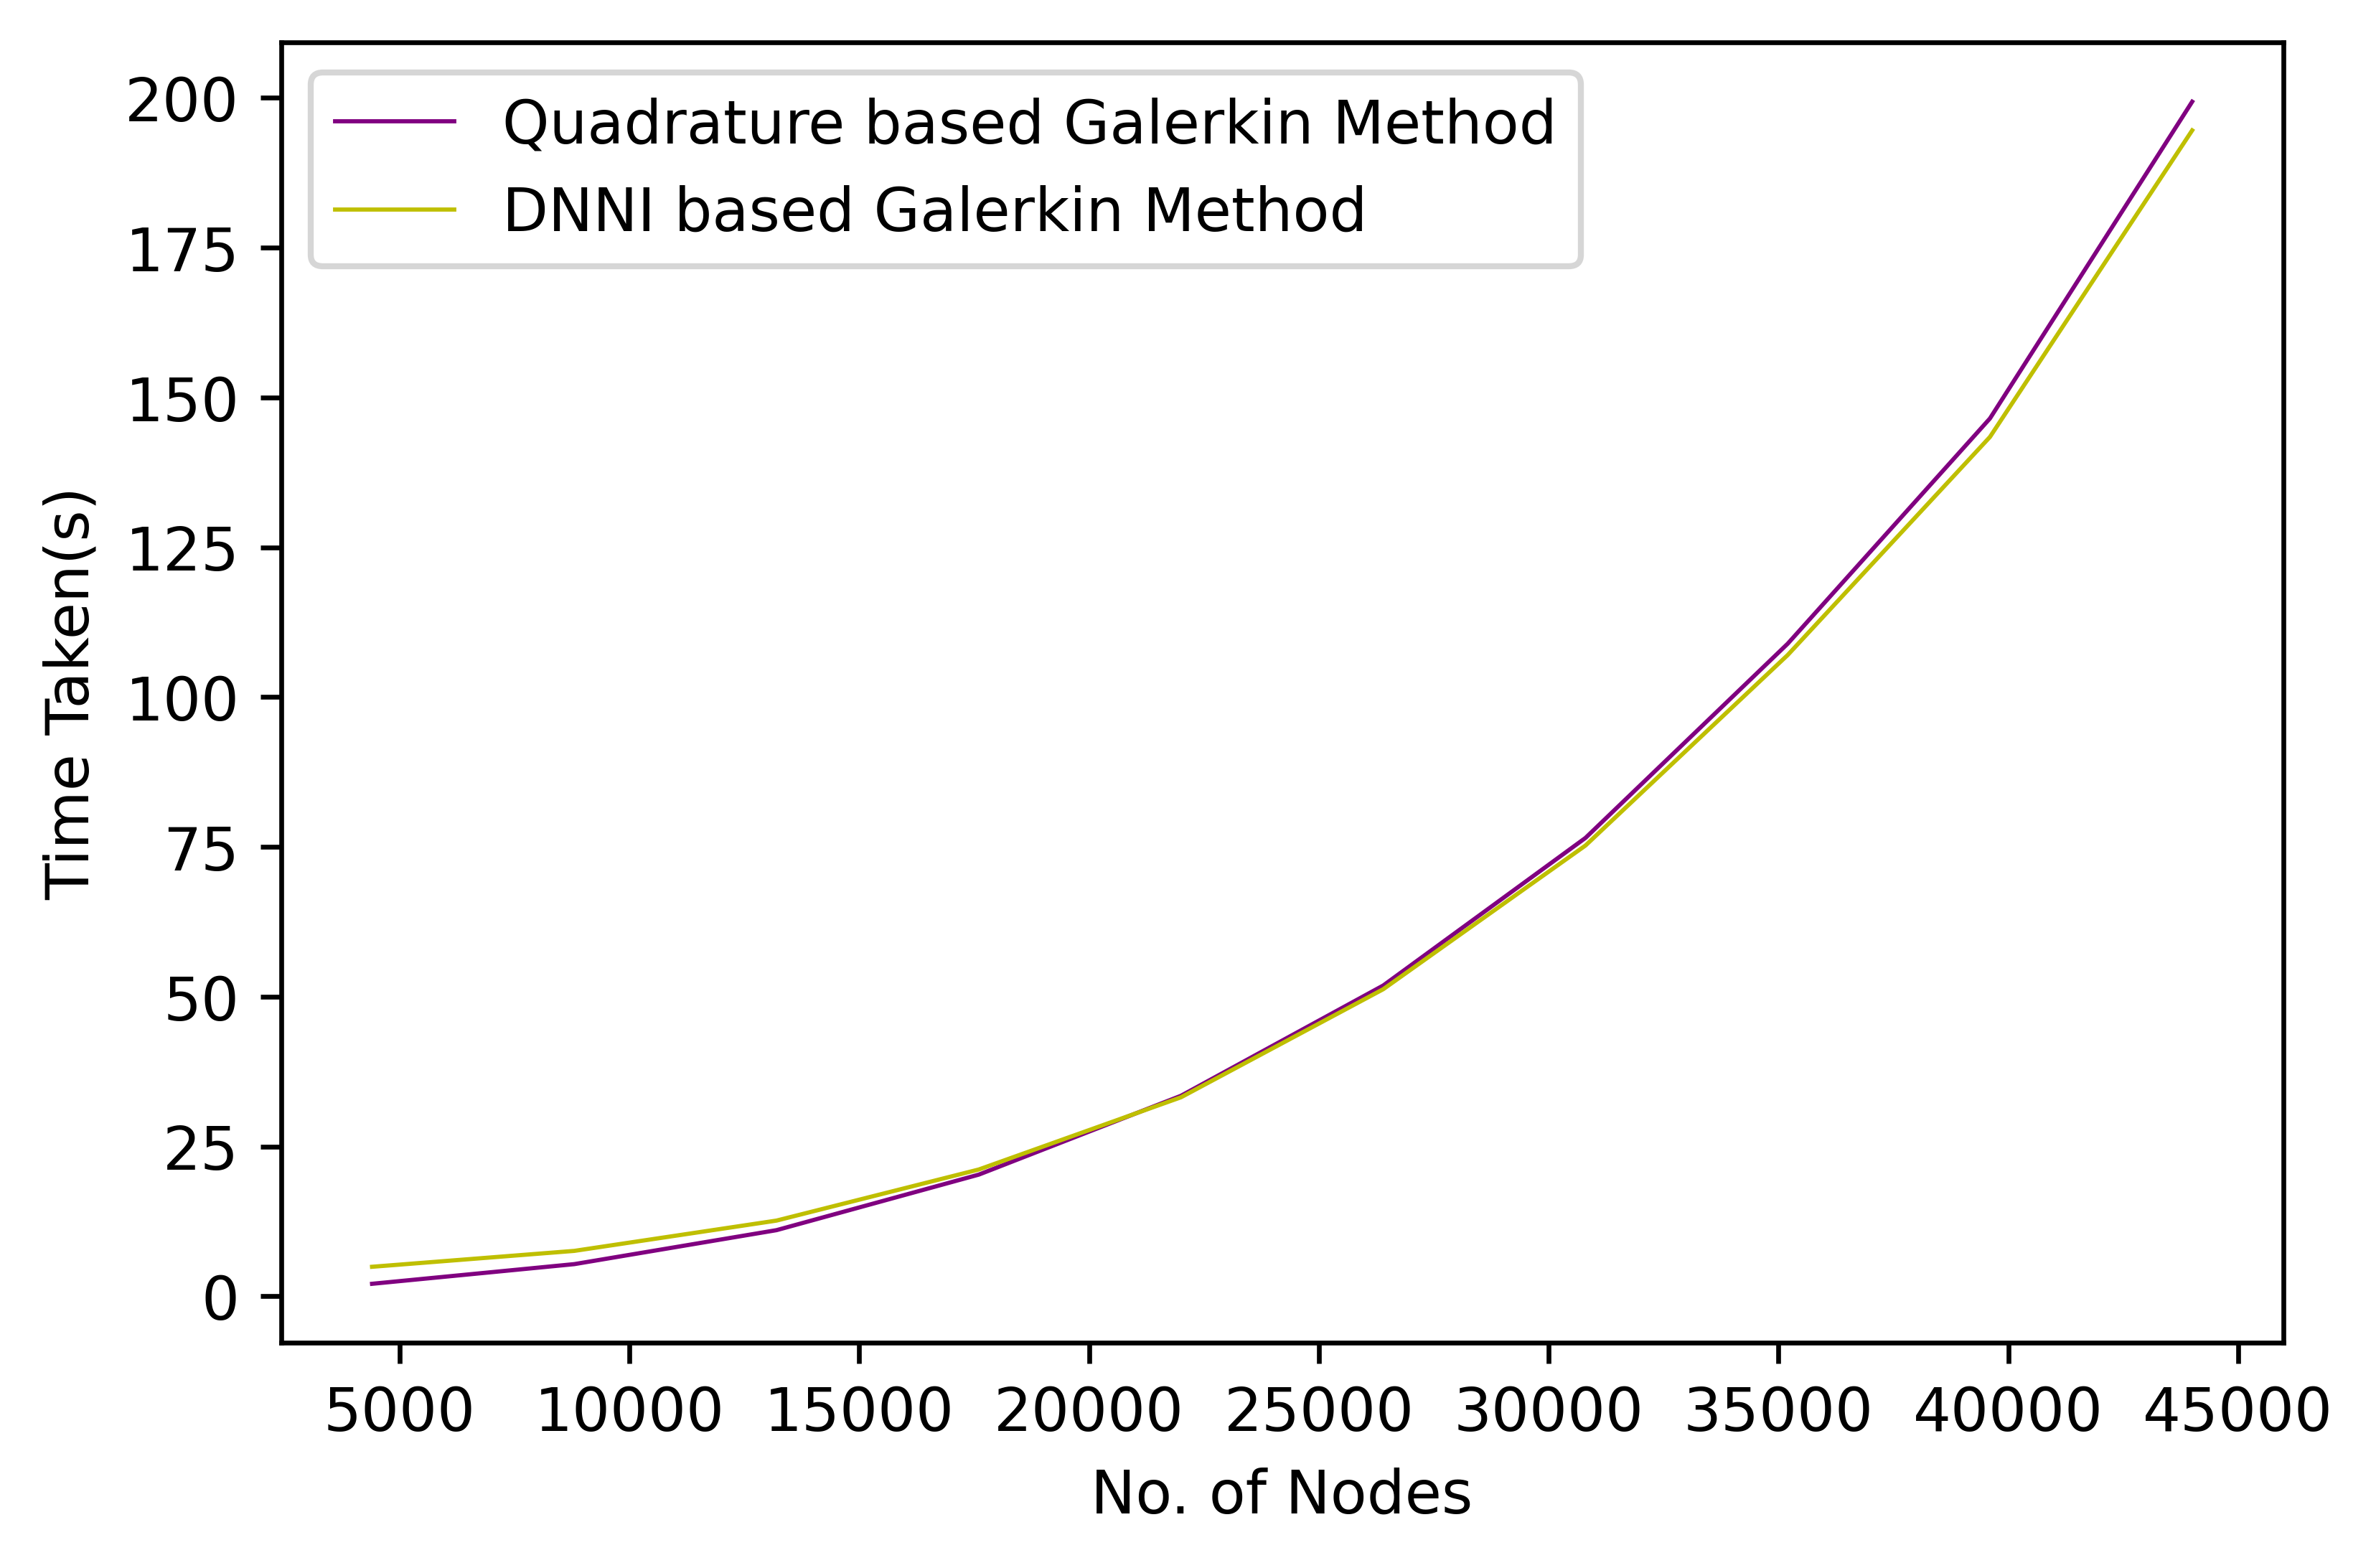

In [24]:
# test 1 (average of 2 iterations)
t1 = np.array(time_gele)
t2 = np.array(time_dnni)
mean_t1 = (t1[0]+t1[1])/2
mean_t2 = (t2[0]+t2[1])/2

fig = plt.figure(dpi=600)
fig.patch.set_facecolor('xkcd:white')
nodes = np.linspace(4400,44000,10)
plt.plot(nodes,np.array(mean_t1),'purple',label='Quadrature based Galerkin Method',linewidth=0.7)
plt.plot(nodes,np.array(mean_t2),'y',label='DNNI based Galerkin Method',linewidth=0.7)
plt.xlabel('No. of Nodes')
plt.ylabel('Time Taken(s)')
plt.legend()
plt.savefig('DE2.png',bbox_inches='tight')

# Test 2

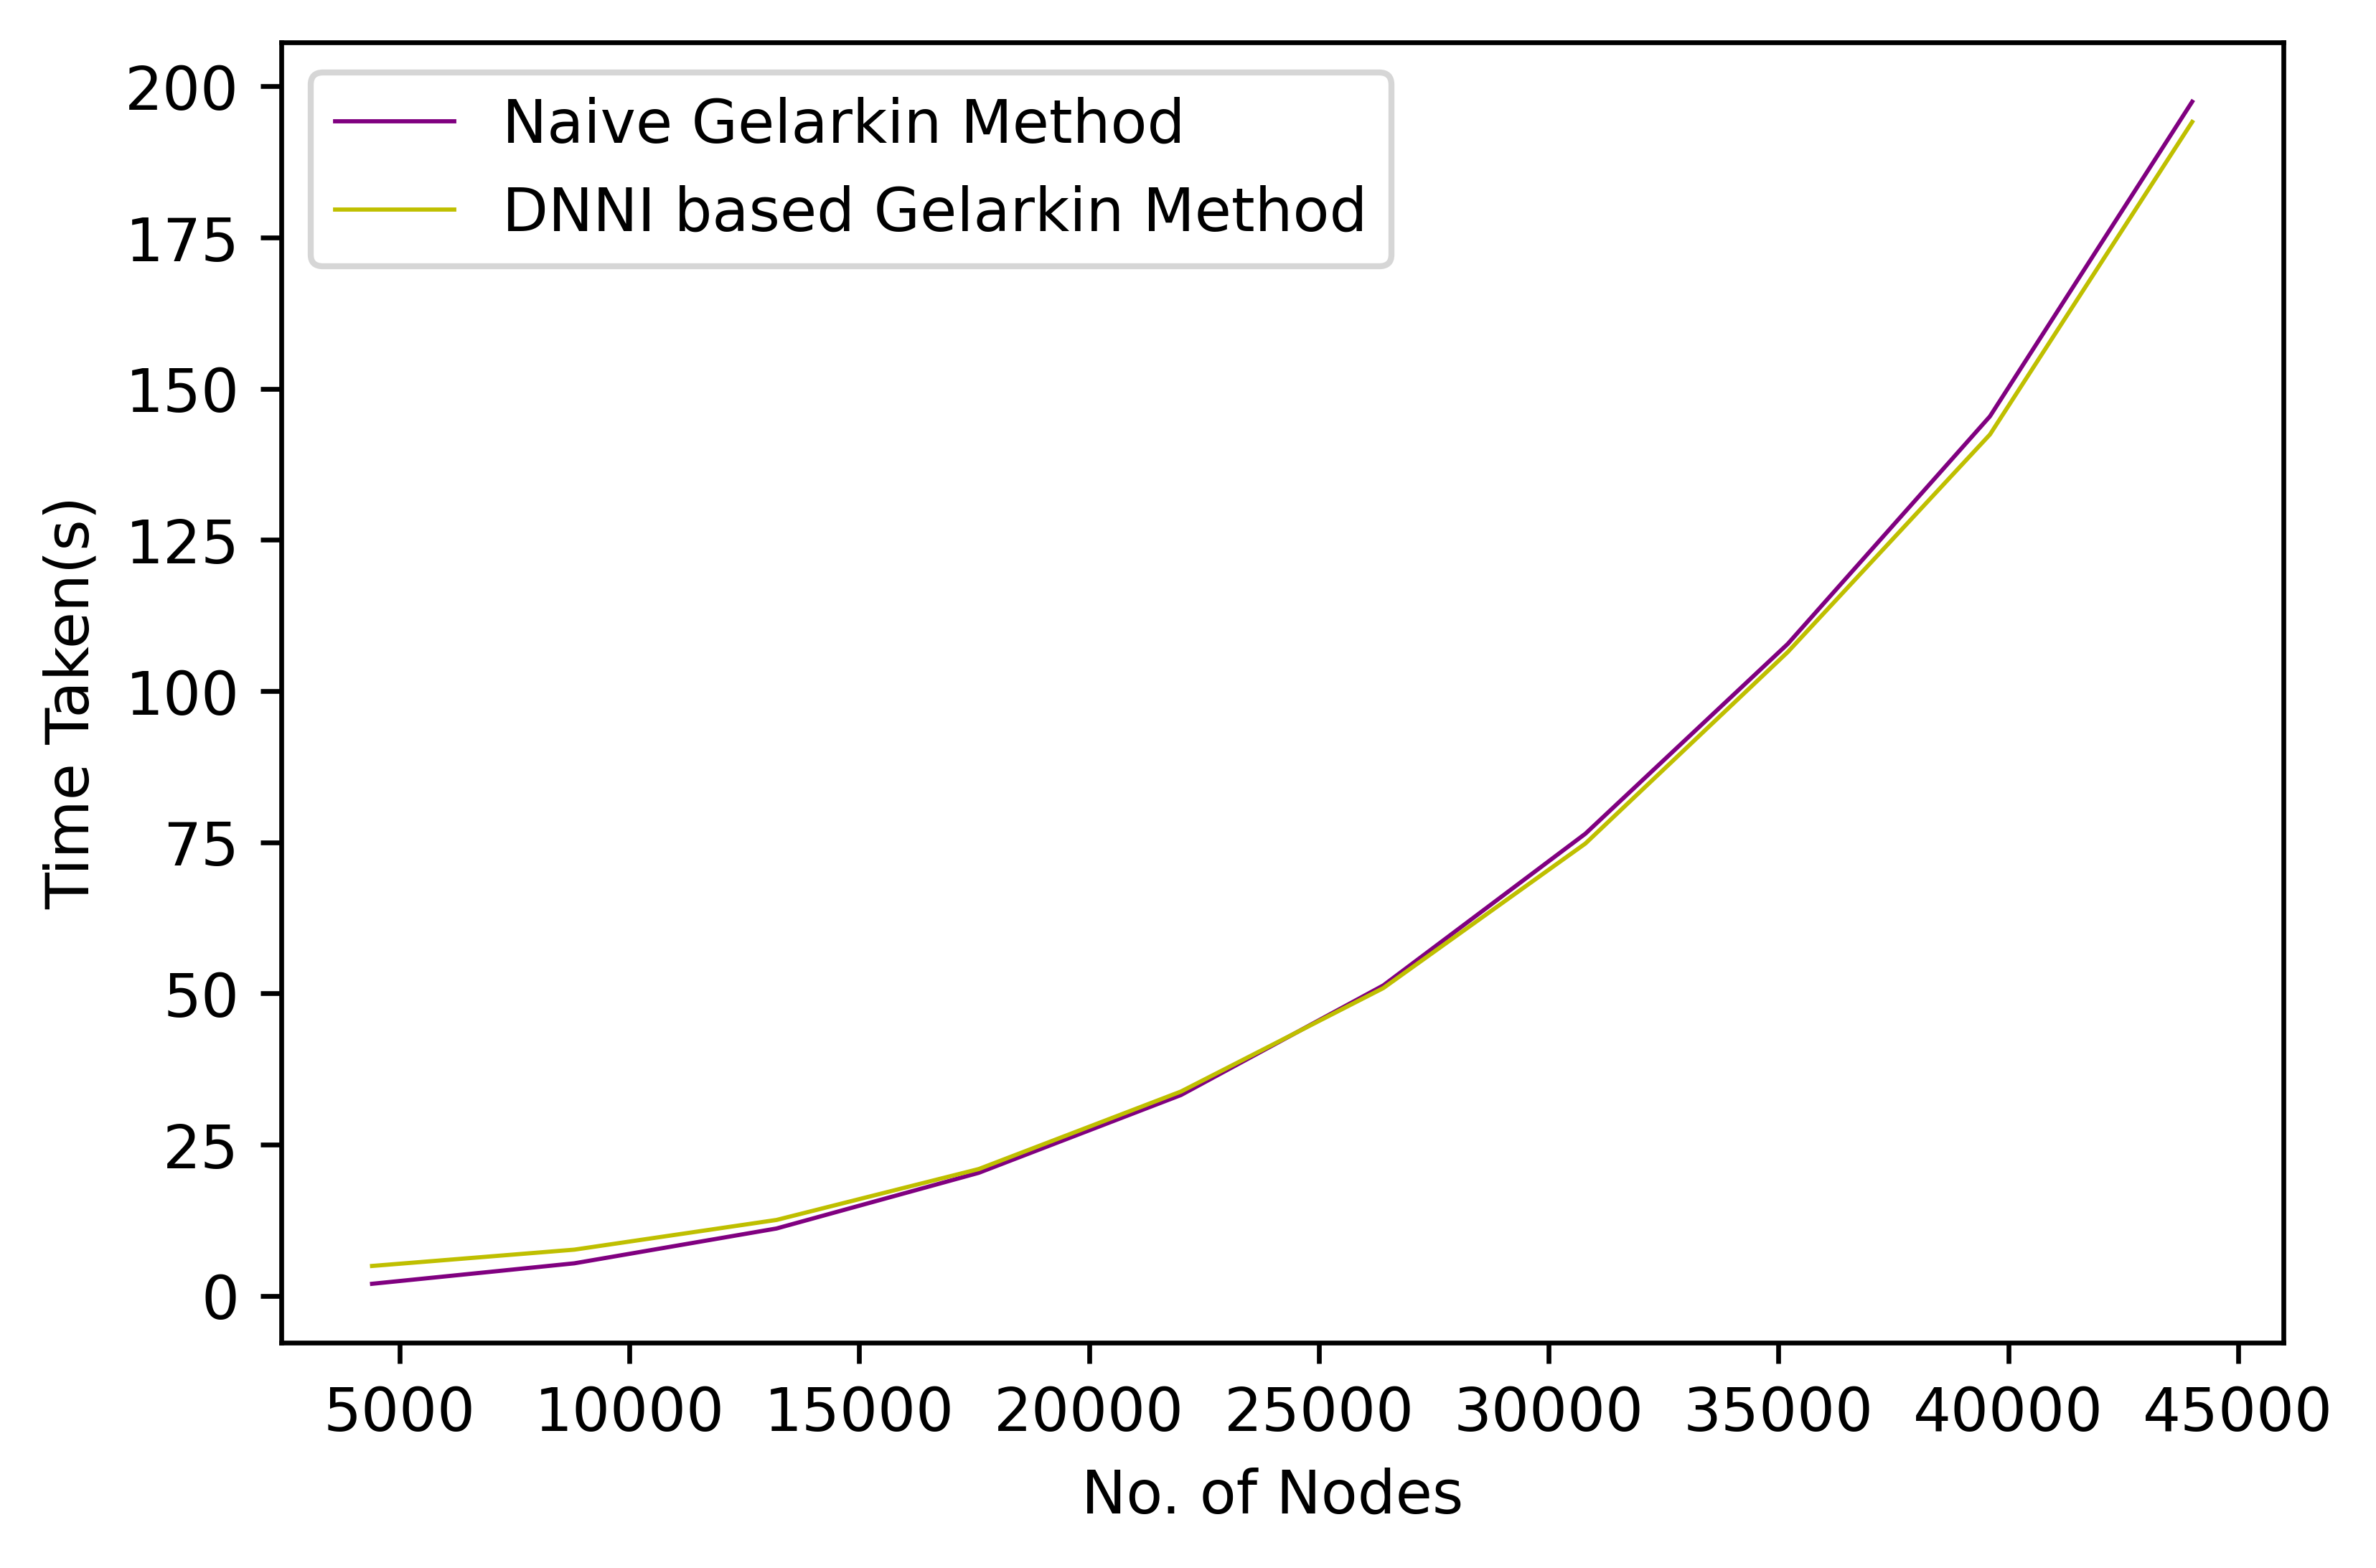

In [34]:
#average of 5 iterations
t1 = np.array(time_gele)
t2 = np.array(time_dnni)
mean_t1 = (t1[0]+t1[1]+t1[2]+t1[3]+t1[4])/5
mean_t2 = (t2[0]+t2[1]+t2[2]+t2[3]+t2[4])/5

fig = plt.figure(dpi=600)
fig.patch.set_facecolor('xkcd:white')
nodes = np.linspace(4400,44000,10)
plt.plot(nodes,np.array(mean_t1),'purple',label='Naive Gelarkin Method',linewidth=0.7)
plt.plot(nodes,np.array(mean_t2),'y',label='DNNI based Gelarkin Method',linewidth=0.7)
plt.xlabel('No. of Nodes ')
plt.ylabel('Time Taken(s) ')
plt.legend()
#plt.savefig('DE2.png',bbox_inches='tight')